In [ ]:
!pip -q install cirq

     |████████████████████████████████| 1.6MB 5.4MB/s 


In [ ]:
import cirq
import numpy as np
from numpy.random import uniform
from matplotlib import pyplot as plt 

In [ ]:
def build_vqc(qubits, symbols):
    (a, b) = qubits
    circ = cirq.Circuit()
    circ.append([cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[0])(a), cirq.rz(symbols[1])(b)], 
                strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rx(symbols[2])(a), cirq.rx(symbols[3])(b)])
    circ.append([cirq.CX(b, a)**symbols[4]])
    return circ


def build_vqc_no_ent(qubits, symbols):
    (a, b) = qubits
    circ = cirq.Circuit()
    # Layer 1
    circ.append([cirq.H(a), cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[0])(a), 
                 cirq.rz(symbols[1])(b)])
    circ.append([cirq.rx(symbols[2])(a), 
                 cirq.rx(symbols[3])(b)])
    # Layer 2
    circ.append([cirq.H(a), cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[4])(a), 
                 cirq.rz(symbols[5])(b)])
    circ.append([cirq.rx(symbols[6])(a), 
                 cirq.rx(symbols[7])(b)])
    # Layer 3
    circ.append([cirq.H(a), cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[8])(a), 
                 cirq.rz(symbols[9])(b)])
    circ.append([cirq.rx(symbols[10])(a), 
                 cirq.rx(symbols[11])(b)])
    return circ


def trace_b(dens_mat):
    return np.asarray([
                       [dens_mat[0][0] + dens_mat[1][1], dens_mat[0][2] + dens_mat[1][3]],
                       [dens_mat[2][0] + dens_mat[3][1], dens_mat[2][2] + dens_mat[3][3]]
                      ]).reshape((2,2))

def trace_a(dens_mat):
    return np.asarray([
                       [dens_mat[0][0] + dens_mat[2][2], dens_mat[0][1] + dens_mat[2][3]],
                       [dens_mat[1][0] + dens_mat[3][2], dens_mat[1][1] + dens_mat[3][3]]
                      ]).reshape((2,2))


def calc_ent(vector):
    dens_mat = cirq.density_matrix_from_state_vector(state_vector=vector)
    avg = []
    p_a = trace_b(dens_mat)
    avg.append(1 - np.matrix.trace(np.linalg.matrix_power(p_a, 2)))
    p_b = trace_a(dens_mat)
    avg.append(1 - np.matrix.trace(np.linalg.matrix_power(p_b, 2)))
    return np.sum(avg)


def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

### Display circuits

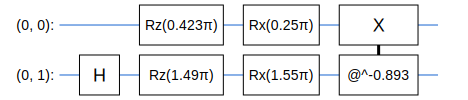

In [ ]:
from cirq.contrib.svg import SVGCircuit

angles = uniform(0, 2 * np.pi, size=4)
pows = uniform(-2, 2, size=1)
values_1 = np.concatenate((angles, pows))
circuit_ent = build_vqc(qubits, values_1)
SVGCircuit(circuit_ent)


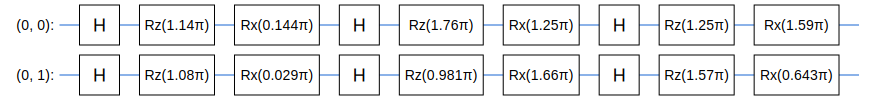

In [ ]:
values = uniform(0, 2 * np.pi, size=12)
circuit_no_ent = build_vqc_no_ent(qubits, values)
SVGCircuit(circuit_no_ent)

### Entangling circuit

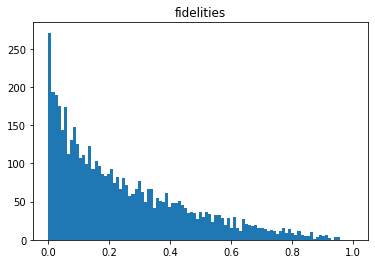

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply


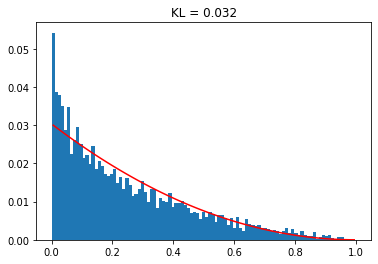




Average entangling capability = 0.377


In [ ]:
a, b = cirq.GridQubit.rect(1, 2)
qubits = (a, b)
s = cirq.Simulator()
NUM_TRIALS = 5000
FIDELITIES = []
ENT = []

for t in range(NUM_TRIALS):
    angles_1 = uniform(0, 2 * np.pi, size=4)
    pows_1 = uniform(-2, 2, size=1)
    values_1 = np.concatenate((angles_1, pows_1))
    circuit_1 = build_vqc(qubits, values_1)
    fin_vec_1 = s.simulate(circuit_1).final_state_vector

    angles_2 = uniform(0, 2 * np.pi, size=4)
    pows_2 = uniform(-2, 2, size=1)
    values_2 = np.concatenate((angles_2, pows_2))
    circuit_2 = build_vqc(qubits, values_2)
    fin_vec_2 = s.simulate(circuit_2).final_state_vector

    fid = cirq.fidelity(fin_vec_1, fin_vec_2)
    FIDELITIES.append(fid)

    ENT.append(calc_ent(fin_vec_1))
    ENT.append(calc_ent(fin_vec_2))

### Histogram of fidelities

n, bins, _ = plt.hist(FIDELITIES, bins=np.linspace(0, 1, num=100)) 
plt.title("fidelities") 
plt.show()

### Normalize and compare to theoretical

bin_centers = np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)])
haar = 3 * (1 - bin_centers)**2

norm_n = n / np.sum(n)
norm_haar = haar / np.sum(haar)

kl = kl_divergence(norm_n, norm_haar)

plt.title(f"KL = {round(kl, 3)}")
plt.bar(bin_centers, n / np.sum(n), width=0.011)
plt.plot(bin_centers, haar / np.sum(haar), c='r')

plt.show()

### Calculate entangling capability

avg_ent_cap = np.mean(ENT)
print(f"\n\n\nAverage entangling capability = {round(avg_ent_cap.real, 3)}")

### Non-entangling circuit

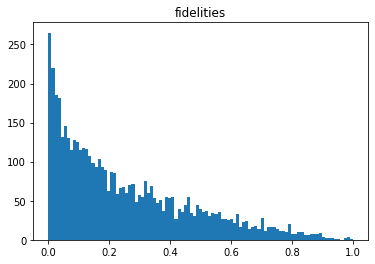

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply


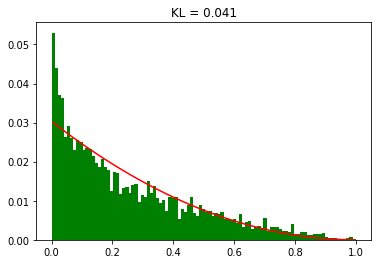




Average entangling capability = 0.0


In [ ]:
a, b = cirq.GridQubit.rect(1, 2)
qubits = (a, b)
s = cirq.Simulator()
NUM_TRIALS = 5000
FIDELITIES = []
ENT = []

for t in range(NUM_TRIALS):
    angles_1 = uniform(0, 2 * np.pi, size=12)
    circuit_1 = build_vqc_no_ent(qubits, angles_1)
    fin_vec_1 = s.simulate(circuit_1).final_state_vector

    angles_2 = uniform(0, 2 * np.pi, size=12)
    circuit_2 = build_vqc_no_ent(qubits, angles_2)
    fin_vec_2 = s.simulate(circuit_2).final_state_vector

    fid = cirq.fidelity(fin_vec_1, fin_vec_2)
    FIDELITIES.append(fid)

    ENT.append(calc_ent(fin_vec_1))
    ENT.append(calc_ent(fin_vec_2))

### Histogram of fidelities

n, bins, _ = plt.hist(FIDELITIES, bins=np.linspace(0, 1, num=100)) 
plt.title("fidelities") 
plt.show()

### Normalize and compare to theoretical

bin_centers = np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)])
haar = 3 * (1 - bin_centers)**2

norm_n = n / np.sum(n)
norm_haar = haar / np.sum(haar)

kl = kl_divergence(norm_n, norm_haar)

plt.title(f"KL = {round(kl, 3)}")
plt.bar(bin_centers, n / np.sum(n), width=0.011, color='g')
plt.plot(bin_centers, haar / np.sum(haar), c='r')

plt.show()

### Calculate entangling capability

avg_ent_cap = np.mean(ENT)
print(f"\n\n\nAverage entangling capability = {round(avg_ent_cap.real, 3)}")